ensemble - 128

In [ ]:
import numpy as np
import tensorflow as tf
import json
import time
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory

def create_model(img_size, num_classes):
    """Create a single EfficientNetB0 model with improved architecture"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),  # Increased dropout
        Dense(256, activation='relu'),  # Wider layer
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_data_augmentation():
    """Create data augmentation pipeline"""
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ])

def ensemble_predict(models, dataset, verbose=True):
    """Make predictions using voting ensemble with detailed logging"""
    # Get individual model predictions
    all_predictions = []
    individual_accuracies = []

    print("\n=== Individual Model Testing ===")
    test_labels = np.concatenate([y.numpy() for x, y in dataset])

    for i, model in enumerate(models):
        # Get model predictions
        predictions = model.predict(dataset, verbose=0)
        class_predictions = np.argmax(predictions, axis=1)
        all_predictions.append(class_predictions)

        # Calculate individual accuracy
        accuracy = np.mean(class_predictions == test_labels)
        individual_accuracies.append(accuracy)
        print(f"Model {i+1} Accuracy: {accuracy:.4f}")

    # Convert to array for voting
    all_predictions = np.array(all_predictions)

    # Implement majority voting
    final_predictions = np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),
        axis=0,
        arr=all_predictions
    )

    # Calculate ensemble accuracy
    ensemble_accuracy = np.mean(final_predictions == test_labels)

    if verbose:
        print("\n=== Ensemble Results ===")
        print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
        print(f"Average Individual Accuracy: {np.mean(individual_accuracies):.4f}")
        print(f"Best Individual Accuracy: {max(individual_accuracies):.4f}")

    return final_predictions, ensemble_accuracy

def train_and_evaluate(train_dir, test_dir, save_dir, img_size, batch_size=32, num_models=3, epochs=10):
    """Train ensemble and collect metrics with improved logging and performance"""
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Load datasets
    print(f"\nLoading datasets for image size {img_size}...")
    train_dataset = image_dataset_from_directory(
        train_dir,
        shuffle=True,
        image_size=img_size,
        batch_size=batch_size
    )

    test_dataset = image_dataset_from_directory(
        test_dir,
        shuffle=False,
        image_size=img_size,
        batch_size=batch_size
    )

    # Get class names
    class_names = train_dataset.class_names
    print(f"Classes: {class_names}")

    # Prepare data for splitting
    print("\nPreparing data splits...")
    train_images = []
    train_labels = []
    for images, labels in train_dataset:
        train_images.append(images.numpy())
        train_labels.append(labels.numpy())
    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)

    # Initialize metrics dictionary
    metrics = {
        "image_size": img_size[0],
        "models": [],
        "ensemble_metrics": {},
        "training_time": time.time()
    }

    # Create data augmentation
    data_augmentation = create_data_augmentation()

    # Train individual models
    models = []
    subset_size = len(train_labels) // num_models
    indices = np.random.permutation(len(train_labels))

    print(f"\nTraining {num_models} models...")
    print(f"Total training samples: {len(train_labels)}")
    print(f"Samples per model: {subset_size}")

    for i in range(num_models):
        print(f"\n=== Training Model {i+1}/{num_models} ===")

        # Get subset of data
        start_idx = i * subset_size
        end_idx = start_idx + subset_size
        subset_indices = indices[start_idx:end_idx]

        # Create dataset for this subset
        subset_images = train_images[subset_indices]
        subset_labels = train_labels[subset_indices]

        # Create augmented dataset
        subset_dataset = tf.data.Dataset.from_tensor_slices(
            (subset_images, subset_labels)
        ).shuffle(1000).map(
            lambda x, y: (data_augmentation(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and train model
        model = create_model(img_size, len(class_names))

        # Add early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )

        # Initial training
        print("\nInitial training phase...")
        history = model.fit(
            subset_dataset,
            validation_data=test_dataset,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1
        )

        # Fine-tuning
        print("\nFine-tuning phase...")
        model.layers[0].trainable = True
        model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        fine_tune_history = model.fit(
            subset_dataset,
            validation_data=test_dataset,
            epochs=5,
            callbacks=[early_stopping],
            verbose=1
        )

        # Collect metrics for this model
        val_accuracy = model.evaluate(test_dataset, verbose=0)[1]
        model_metrics = {
            "model_id": i+1,
            "best_epoch_accuracy": max(history.history['val_accuracy']),
            "final_accuracy": val_accuracy,
            "learning_curves": {
                "accuracy": history.history['accuracy'] + fine_tune_history.history['accuracy'],
                "val_accuracy": history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
                "loss": history.history['loss'] + fine_tune_history.history['loss'],
                "val_loss": history.history['val_loss'] + fine_tune_history.history['val_loss']
            }
        }
        metrics["models"].append(model_metrics)
        models.append(model)

    # Ensemble evaluation
    print("\nEvaluating ensemble performance...")
    ensemble_preds, ensemble_accuracy = ensemble_predict(models, test_dataset)
    test_labels = np.concatenate([y.numpy() for x, y in test_dataset])

    # Calculate confusion matrix
    conf_mat = confusion_matrix(test_labels, ensemble_preds)

    # Calculate ROC curves
    roc_curves = []
    for class_idx in range(len(class_names)):
        # Get predictions for this class from all models
        class_probs = np.zeros(len(test_labels))
        for model in models:
            class_probs += model.predict(test_dataset, verbose=0)[:, class_idx]
        class_probs /= len(models)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(test_labels == class_idx, class_probs)
        roc_auc = auc(fpr, tpr)
        roc_curves.append({
            "class": class_names[class_idx],
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": float(roc_auc)
        })

    # Add ensemble metrics
    metrics["ensemble_metrics"] = {
        "accuracy": float(ensemble_accuracy),
        "confusion_matrix": conf_mat.tolist(),
        "roc_curves": roc_curves
    }

    # Add total training time
    metrics["training_time"] = time.time() - metrics["training_time"]

    # Save metrics
    save_path = os.path.join(save_dir, f"metrics_size_{img_size[0]}.json")
    with open(save_path, 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"\nMetrics saved to: {save_path}")
    return models, metrics

if __name__ == "__main__":
    # Configuration
    train_dir = '/content/drive/MyDrive/model training(2)/train'
    test_dir = '/content/drive/MyDrive/model training(2)/efficientnet/test'
    save_dir = '/content/drive/MyDrive/model training(2)/efficientnet'

    # Image sizes to test
    img_sizes = [(128, 128), (256, 256), (512, 512)]

    # Train and evaluate for each image size
    for img_size in img_sizes:
        print(f"\n{'='*50}")
        print(f"Training ensemble for image size: {img_size}")
        print(f"{'='*50}")

        models, metrics = train_and_evaluate(
            train_dir=train_dir,
            test_dir=test_dir,
            save_dir=save_dir,
            img_size=img_size,
            batch_size=32,
            num_models=3,
            epochs=10
        )

        print(f"\nCompleted training for size {img_size[0]}x{img_size[0]}")
        print(f"Ensemble accuracy: {metrics['ensemble_metrics']['accuracy']:.4f}")
        print(f"{'='*50}\n")


Training ensemble for image size: (128, 128)

Loading datasets for image size (128, 128)...
Found 2390 files belonging to 4 classes.
Found 618 files belonging to 4 classes.
Classes: ['heavy traffic', 'light traffic', 'moderate traffic', 'no traffic']

Preparing data splits...

Training 3 models...
Total training samples: 2390
Samples per model: 796

=== Training Model 1/3 ===

Initial training phase...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4060 - loss: 1.3254 - val_accuracy: 0.4061 - val_loss: 1.2726
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5536 - loss: 1.0467 - val_accuracy: 0.4369 - val_loss: 1.2267
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5495 - loss: 0.9641 - val_accuracy: 0.4903 - val_loss: 1.1452
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5687 - loss: 0.9896 - val_accuracy: 0.4741 - val_loss: 1.2015
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5722 - loss: 0.9615 - val

ensemble-256

In [ ]:
import numpy as np
import tensorflow as tf
import json
import time
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory

def create_model(img_size, num_classes):
    """Create a single EfficientNetB0 model with improved architecture"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),  # Increased dropout
        Dense(256, activation='relu'),  # Wider layer
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_data_augmentation():
    """Create data augmentation pipeline"""
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ])

def ensemble_predict(models, dataset, verbose=True):
    """Make predictions using voting ensemble with detailed logging"""
    # Get individual model predictions
    all_predictions = []
    individual_accuracies = []

    print("\n=== Individual Model Testing ===")
    test_labels = np.concatenate([y.numpy() for x, y in dataset])

    for i, model in enumerate(models):
        # Get model predictions
        predictions = model.predict(dataset, verbose=0)
        class_predictions = np.argmax(predictions, axis=1)
        all_predictions.append(class_predictions)

        # Calculate individual accuracy
        accuracy = np.mean(class_predictions == test_labels)
        individual_accuracies.append(accuracy)
        print(f"Model {i+1} Accuracy: {accuracy:.4f}")

    # Convert to array for voting
    all_predictions = np.array(all_predictions)

    # Implement majority voting
    final_predictions = np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),
        axis=0,
        arr=all_predictions
    )

    # Calculate ensemble accuracy
    ensemble_accuracy = np.mean(final_predictions == test_labels)

    if verbose:
        print("\n=== Ensemble Results ===")
        print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
        print(f"Average Individual Accuracy: {np.mean(individual_accuracies):.4f}")
        print(f"Best Individual Accuracy: {max(individual_accuracies):.4f}")

    return final_predictions, ensemble_accuracy

def train_and_evaluate(train_dir, test_dir, save_dir, img_size, batch_size=32, num_models=3, epochs=10):
    """Train ensemble and collect metrics with improved logging and performance"""
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Load datasets
    print(f"\nLoading datasets for image size {img_size}...")
    train_dataset = image_dataset_from_directory(
        train_dir,
        shuffle=True,
        image_size=img_size,
        batch_size=batch_size
    )

    test_dataset = image_dataset_from_directory(
        test_dir,
        shuffle=False,
        image_size=img_size,
        batch_size=batch_size
    )

    # Get class names
    class_names = train_dataset.class_names
    print(f"Classes: {class_names}")

    # Prepare data for splitting
    print("\nPreparing data splits...")
    train_images = []
    train_labels = []
    for images, labels in train_dataset:
        train_images.append(images.numpy())
        train_labels.append(labels.numpy())
    train_images = np.concatenate(train_images)
    train_labels = np.concatenate(train_labels)

    # Initialize metrics dictionary
    metrics = {
        "image_size": img_size[0],
        "models": [],
        "ensemble_metrics": {},
        "training_time": time.time()
    }

    # Create data augmentation
    data_augmentation = create_data_augmentation()

    # Train individual models
    models = []
    subset_size = len(train_labels) // num_models
    indices = np.random.permutation(len(train_labels))

    print(f"\nTraining {num_models} models...")
    print(f"Total training samples: {len(train_labels)}")
    print(f"Samples per model: {subset_size}")

    for i in range(num_models):
        print(f"\n=== Training Model {i+1}/{num_models} ===")

        # Get subset of data
        start_idx = i * subset_size
        end_idx = start_idx + subset_size
        subset_indices = indices[start_idx:end_idx]

        # Create dataset for this subset
        subset_images = train_images[subset_indices]
        subset_labels = train_labels[subset_indices]

        # Create augmented dataset
        subset_dataset = tf.data.Dataset.from_tensor_slices(
            (subset_images, subset_labels)
        ).shuffle(1000).map(
            lambda x, y: (data_augmentation(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # Create and train model
        model = create_model(img_size, len(class_names))

        # Add early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )

        # Initial training
        print("\nInitial training phase...")
        history = model.fit(
            subset_dataset,
            validation_data=test_dataset,
            epochs=epochs,
            callbacks=[early_stopping],
            verbose=1
        )

        # Fine-tuning
        print("\nFine-tuning phase...")
        model.layers[0].trainable = True
        model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        fine_tune_history = model.fit(
            subset_dataset,
            validation_data=test_dataset,
            epochs=5,
            callbacks=[early_stopping],
            verbose=1
        )

        # Collect metrics for this model
        val_accuracy = model.evaluate(test_dataset, verbose=0)[1]
        model_metrics = {
            "model_id": i+1,
            "best_epoch_accuracy": max(history.history['val_accuracy']),
            "final_accuracy": val_accuracy,
            "learning_curves": {
                "accuracy": history.history['accuracy'] + fine_tune_history.history['accuracy'],
                "val_accuracy": history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'],
                "loss": history.history['loss'] + fine_tune_history.history['loss'],
                "val_loss": history.history['val_loss'] + fine_tune_history.history['val_loss']
            }
        }
        metrics["models"].append(model_metrics)
        models.append(model)

    # Ensemble evaluation
    print("\nEvaluating ensemble performance...")
    ensemble_preds, ensemble_accuracy = ensemble_predict(models, test_dataset)
    test_labels = np.concatenate([y.numpy() for x, y in test_dataset])

    # Calculate confusion matrix
    conf_mat = confusion_matrix(test_labels, ensemble_preds)

    # Calculate ROC curves
    roc_curves = []
    for class_idx in range(len(class_names)):
        # Get predictions for this class from all models
        class_probs = np.zeros(len(test_labels))
        for model in models:
            class_probs += model.predict(test_dataset, verbose=0)[:, class_idx]
        class_probs /= len(models)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(test_labels == class_idx, class_probs)
        roc_auc = auc(fpr, tpr)
        roc_curves.append({
            "class": class_names[class_idx],
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": float(roc_auc)
        })

    # Add ensemble metrics
    metrics["ensemble_metrics"] = {
        "accuracy": float(ensemble_accuracy),
        "confusion_matrix": conf_mat.tolist(),
        "roc_curves": roc_curves
    }

    # Add total training time
    metrics["training_time"] = time.time() - metrics["training_time"]

    # Save metrics
    save_path = os.path.join(save_dir, f"metrics_size_{img_size[0]}.json")
    with open(save_path, 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"\nMetrics saved to: {save_path}")
    return models, metrics

if __name__ == "__main__":
    # Configuration
    train_dir = '/content/drive/MyDrive/model training(2)/train'
    test_dir = '/content/drive/MyDrive/model training(2)/efficientnet/test'
    save_dir = '/content/drive/MyDrive/model training(2)/efficientnet'

    # Image sizes to test
    img_sizes = [(256, 256)]

    # Train and evaluate for each image size
    for img_size in img_sizes:
        print(f"\n{'='*50}")
        print(f"Training ensemble for image size: {img_size}")
        print(f"{'='*50}")

        models, metrics = train_and_evaluate(
            train_dir=train_dir,
            test_dir=test_dir,
            save_dir=save_dir,
            img_size=img_size,
            batch_size=32,
            num_models=3,
            epochs=10
        )

        print(f"\nCompleted training for size {img_size[0]}x{img_size[0]}")
        print(f"Ensemble accuracy: {metrics['ensemble_metrics']['accuracy']:.4f}")
        print(f"{'='*50}\n")


Training ensemble for image size: (256, 256)

Loading datasets for image size (256, 256)...
Found 2390 files belonging to 4 classes.
Found 618 files belonging to 4 classes.
Classes: ['heavy traffic', 'light traffic', 'moderate traffic', 'no traffic']

Preparing data splits...

Training 3 models...
Total training samples: 2390
Samples per model: 796

=== Training Model 1/3 ===

Initial training phase...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.4092 - loss: 1.3124 - val_accuracy: 0.3447 - val_loss: 1.3340
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.5509 - loss: 1.0069 - val_accuracy: 0.4773 - val_loss: 1.1699
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 172s 7s/step - accuracy: 0.5673 - loss: 0.9733 - val_accuracy: 0.4854 - val_loss: 1.2039
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 179s 6s/step - accuracy: 0.6265 - loss: 0.8705 - val_accuracy: 0.4919 - val_loss: 1.1576
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 221s 7s/step - accuracy: 0.6248 - loss: 0.8375 

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Plot saved to: /content/drive/MyDrive/CNN_Training_Time_vs_Image_Size.png


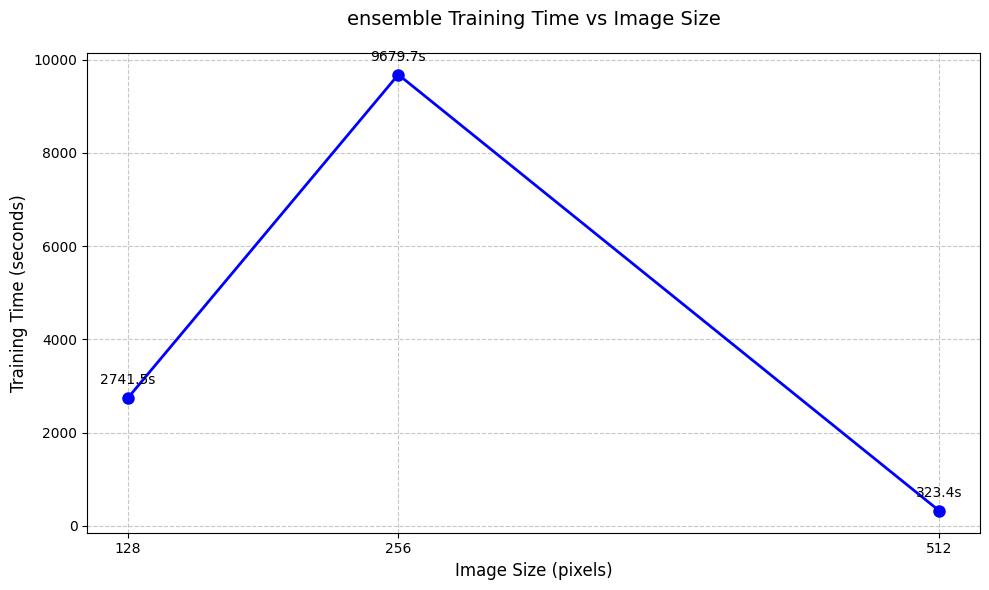


Training times for each image size:
Image size 128x128: 2741.51 seconds
Image size 256x256: 9679.74 seconds
Image size 512x512: 323.40 seconds


In [ ]:
import json
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the full paths to your three JSON files
json_file_128 = '/content/drive/MyDrive/model training(2)/json/metrics_size_128 (1).json'  # Update this path
json_file_256 = '/content/drive/MyDrive/model training(2)/json/metrics_size_256.json'  # Update this path
json_file_512 = '/content/drive/MyDrive/model training(2)/json/metrics_size_512 (1).json'  # Update this path

# Create lists to store data
image_sizes = []
training_times = []

# Read data from JSON files
json_files = [json_file_128, json_file_256, json_file_512]

for file_path in json_files:
    try:
        with open(file_path, 'r') as f:
            metrics = json.load(f)
            image_sizes.append(metrics['image_size'])
            training_times.append(metrics['training_time'])
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")

# Sort by image size
sorted_data = sorted(zip(image_sizes, training_times))
image_sizes, training_times = zip(*sorted_data)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot data
plt.plot(image_sizes, training_times, 'bo-', linewidth=2, markersize=8)

# Customize plot
plt.title('ensemble Training Time vs Image Size', fontsize=14, pad=20)
plt.xlabel('Image Size (pixels)', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add data point labels
for size, time in zip(image_sizes, training_times):
    plt.annotate(f'{time:.1f}s',
                (size, time),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Set x-axis ticks
plt.xticks(image_sizes)

# Adjust layout
plt.tight_layout()

# Save plot
save_path = '/content/drive/MyDrive/CNN_Training_Time_vs_Image_Size.png'  # Update this path
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

# Display plot
plt.show()

# Print data for verification
print("\nTraining times for each image size:")
for size, time in zip(image_sizes, training_times):
    print(f"Image size {size}x{size}: {time:.2f} seconds")

ROC curve

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Plot saved to: /content/drive/MyDrive/Ensemble_EfficientNet_ROC_Curves.png


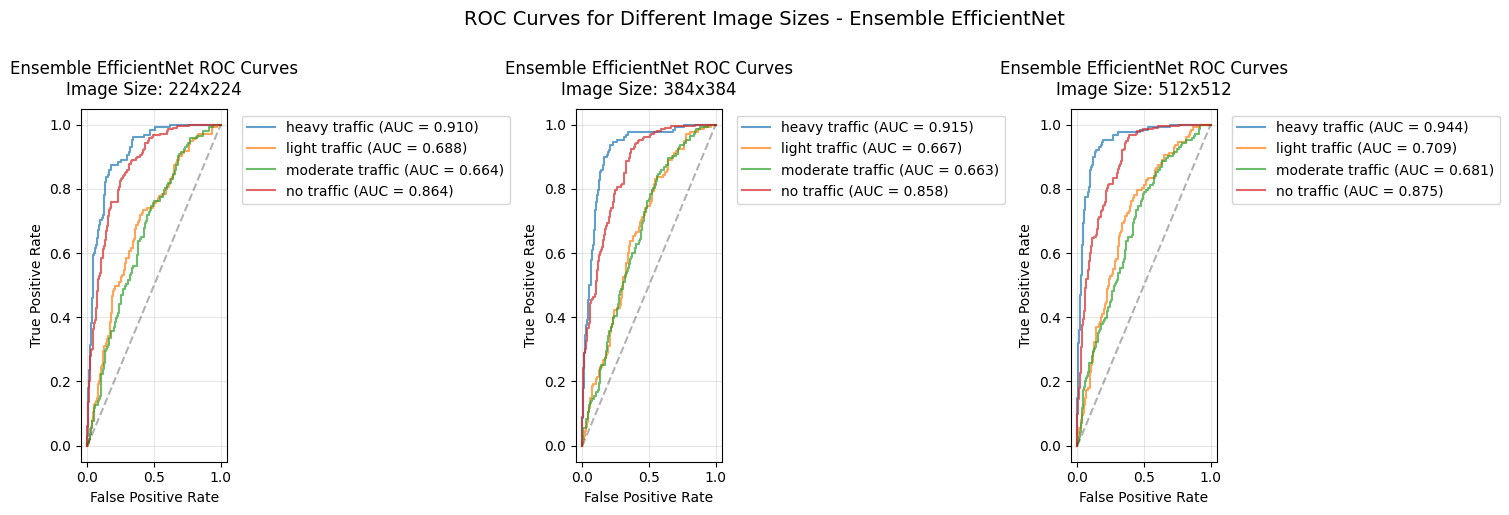


AUC Scores Summary:

Image Size: 224x224
heavy traffic: AUC = 0.910
light traffic: AUC = 0.688
moderate traffic: AUC = 0.664
no traffic: AUC = 0.864

Image Size: 384x384
heavy traffic: AUC = 0.915
light traffic: AUC = 0.667
moderate traffic: AUC = 0.663
no traffic: AUC = 0.858

Image Size: 512x512
heavy traffic: AUC = 0.944
light traffic: AUC = 0.709
moderate traffic: AUC = 0.681
no traffic: AUC = 0.875


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify paths to your three JSON files
json_file_128 = '/content/drive/MyDrive/model training(2)/json/metrics_size_128 (1).json'  # Update this path
json_file_256 = '/content/drive/MyDrive/model training(2)/json/metrics_size_256.json'  # Update this path
json_file_512 = '/content/drive/MyDrive/model training(2)/json/metrics_size_512 (1).json'  # Update this path

# Create figure
plt.figure(figsize=(15, 5))

# Colors for different image sizes
colors = ['blue', 'green', 'red']
sizes = [224, 384, 512]
json_files = [json_file_128, json_file_256, json_file_512]

# Create subplots for each image size
for idx, (size, json_file, color) in enumerate(zip(sizes, json_files, colors)):
    plt.subplot(1, 3, idx + 1)

    # Load metrics from JSON
    try:
        with open(json_file, 'r') as f:
            metrics = json.load(f)

        # Get ROC curves data
        roc_curves = metrics['ensemble_metrics']['roc_curves']

        # Plot ROC curve for each class
        for class_data in roc_curves:
            class_name = class_data['class']
            fpr = class_data['fpr']
            tpr = class_data['tpr']
            auc_score = class_data['auc']

            plt.plot(fpr, tpr,
                    label=f'{class_name} (AUC = {auc_score:.3f})',
                    alpha=0.7)

        # Plot random guess line
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

        # Customize plot
        plt.title(f'Ensemble EfficientNet ROC Curves\nImage Size: {size}x{size}',
                 pad=10)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

    except Exception as e:
        print(f"Error processing file for size {size}: {str(e)}")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add overall title
plt.suptitle('ROC Curves for Different Image Sizes - Ensemble EfficientNet',
             fontsize=14,
             y=1.02)

# Save plot
save_path = '/content/drive/MyDrive/Ensemble_EfficientNet_ROC_Curves.png'  # Update path
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

# Display plot
plt.show()

# Print AUC scores summary
print("\nAUC Scores Summary:")
for size, json_file in zip(sizes, json_files):
    print(f"\nImage Size: {size}x{size}")
    try:
        with open(json_file, 'r') as f:
            metrics = json.load(f)
        for curve in metrics['ensemble_metrics']['roc_curves']:
            print(f"{curve['class']}: AUC = {curve['auc']:.3f}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Plot saved to: /content/drive/MyDrive/Ensemble_EfficientNet_ROC_Curves_Simple.png


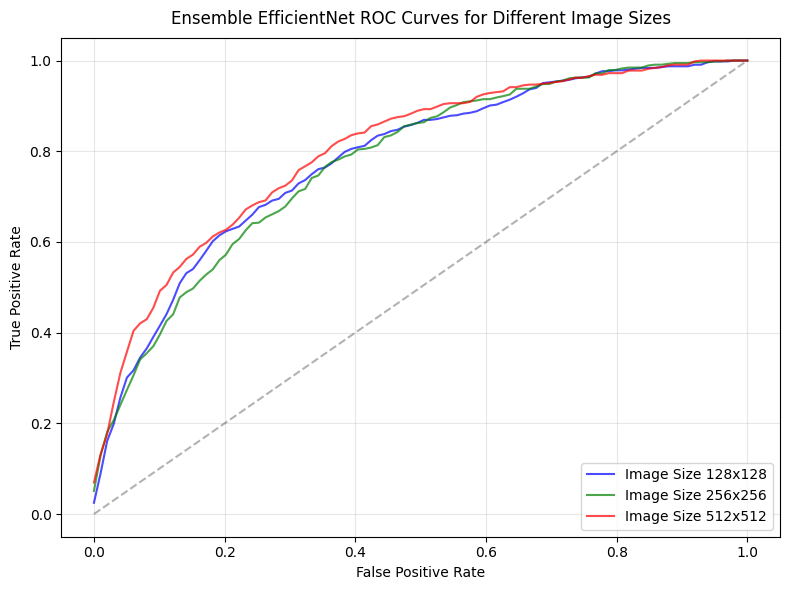


AUC Scores Summary:

Image Size: 128x128
Average AUC = 0.782

Image Size: 256x256
Average AUC = 0.776

Image Size: 512x512
Average AUC = 0.802


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify paths to your three JSON files
json_file_128 = '/content/drive/MyDrive/model training(2)/json/metrics_size_128 (1).json'  # Update this path
json_file_256 = '/content/drive/MyDrive/model training(2)/json/metrics_size_256.json'  # Update this path
json_file_512 = '/content/drive/MyDrive/model training(2)/json/metrics_size_512 (1).json'  # Update this path

# Create figure
plt.figure(figsize=(8, 6))

# Colors for different image sizes
colors = ['blue', 'green', 'red']
sizes = [128, 256, 512]
json_files = [json_file_128, json_file_256, json_file_512]

# Loop through the different image sizes and plot one ROC curve for each
for idx, (size, json_file, color) in enumerate(zip(sizes, json_files, colors)):
    # Load metrics from JSON
    try:
        with open(json_file, 'r') as f:
            metrics = json.load(f)

        # Get average ROC curve data (combining all class ROC curves)
        roc_curves = metrics['ensemble_metrics']['roc_curves']

        # Compute the average ROC curve by averaging the FPR and TPR across classes
        avg_fpr = np.linspace(0, 1, 100)  # Fixed range of FPR for averaging
        avg_tpr = np.zeros_like(avg_fpr)

        for class_data in roc_curves:
            fpr = np.array(class_data['fpr'])
            tpr = np.array(class_data['tpr'])
            avg_tpr += np.interp(avg_fpr, fpr, tpr)

        # Average the TPR across all classes
        avg_tpr /= len(roc_curves)

        # Plot the average ROC curve for the image size
        plt.plot(avg_fpr, avg_tpr, label=f'Image Size {size}x{size}', color=color, alpha=0.7)

    except Exception as e:
        print(f"Error processing file for size {size}: {str(e)}")

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

# Customize plot
plt.title('Ensemble EfficientNet ROC Curves for Different Image Sizes', pad=10)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()

# Save plot
save_path = '/content/drive/MyDrive/Ensemble_EfficientNet_ROC_Curves_Simple.png'  # Update path
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

# Display plot
plt.show()

# Print AUC scores summary for each image size
print("\nAUC Scores Summary:")
for size, json_file in zip(sizes, json_files):
    print(f"\nImage Size: {size}x{size}")
    try:
        with open(json_file, 'r') as f:
            metrics = json.load(f)
        avg_auc = np.mean([curve['auc'] for curve in metrics['ensemble_metrics']['roc_curves']])
        print(f"Average AUC = {avg_auc:.3f}")
    except Exception as e:
        print(f"Error reading file: {str(e)}")


learning curve

Plot saved to: /content/drive/MyDrive/Ensemble_Training_Curves_Accuracy_Loss.png


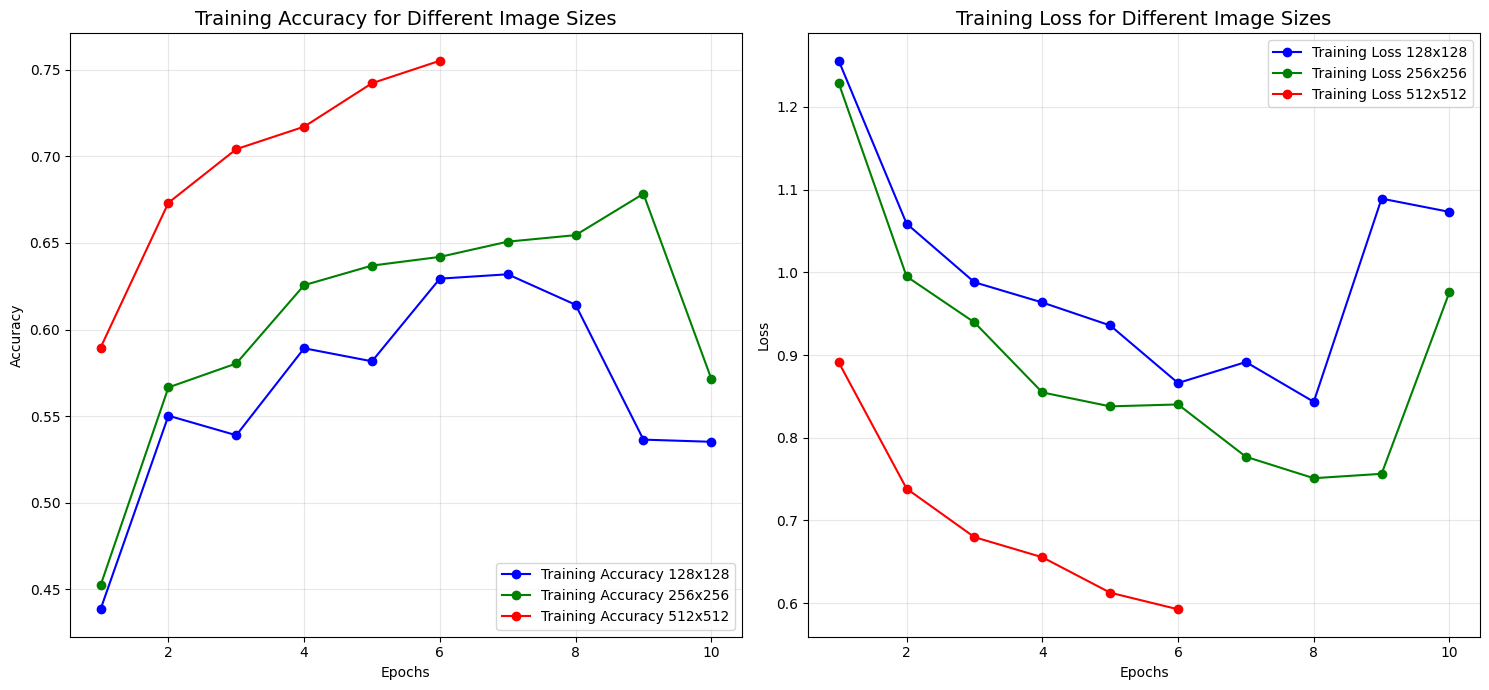

In [ ]:
import json
import matplotlib.pyplot as plt

# Specify paths to your three JSON files
json_file_128 = '/content/drive/MyDrive/model training(2)/json/metrics_size_128 (1).json'  # Update path
json_file_256 = '/content/drive/MyDrive/model training(2)/json/metrics_size_256.json'  # Update path
json_file_512 = '/content/drive/MyDrive/model training(2)/json/metrics_size_512 (1).json'  # Update path

# Create figure with 2 subplots (one for accuracy and one for loss)
plt.figure(figsize=(15, 7))

# Colors for different image sizes
colors = ['blue', 'green', 'red']
sizes = [128, 256, 512]
json_files = [json_file_128, json_file_256, json_file_512]

# Loop through the different image sizes and plot both accuracy and loss for each
for idx, (size, json_file, color) in enumerate(zip(sizes, json_files, colors)):
    # Load metrics from JSON
    try:
        with open(json_file, 'r') as f:
            metrics = json.load(f)

        # Extract learning curve data (accuracy and loss)
        accuracy = metrics['models'][0]['learning_curves']['accuracy'][:10]  # Limit to first 10 epochs
        loss = metrics['models'][0]['learning_curves']['loss'][:10]  # Limit to first 10 epochs
        epochs = range(1, len(accuracy) + 1)

        # Plot training accuracy
        plt.subplot(1, 2, 1)  # Plot in the first subplot (left side)
        plt.plot(epochs, accuracy, label=f'Training Accuracy {size}x{size}', color=color, linestyle='-', marker='o')

        # Plot training loss
        plt.subplot(1, 2, 2)  # Plot in the second subplot (right side)
        plt.plot(epochs, loss, label=f'Training Loss {size}x{size}', color=color, linestyle='-', marker='o')

    except Exception as e:
        print(f"Error processing file for size {size}: {str(e)}")

# Customize accuracy plot
plt.subplot(1, 2, 1)
plt.title('Training Accuracy for Different Image Sizes', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')

# Customize loss plot
plt.subplot(1, 2, 2)
plt.title('Training Loss for Different Image Sizes', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save plot
save_path = '/content/drive/MyDrive/Ensemble_Training_Curves_Accuracy_Loss.png'  # Update path
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

# Display plot
plt.show()


confusion matrices

Plot saved to: /content/drive/MyDrive/Confusion_Matrices_4_Types.png


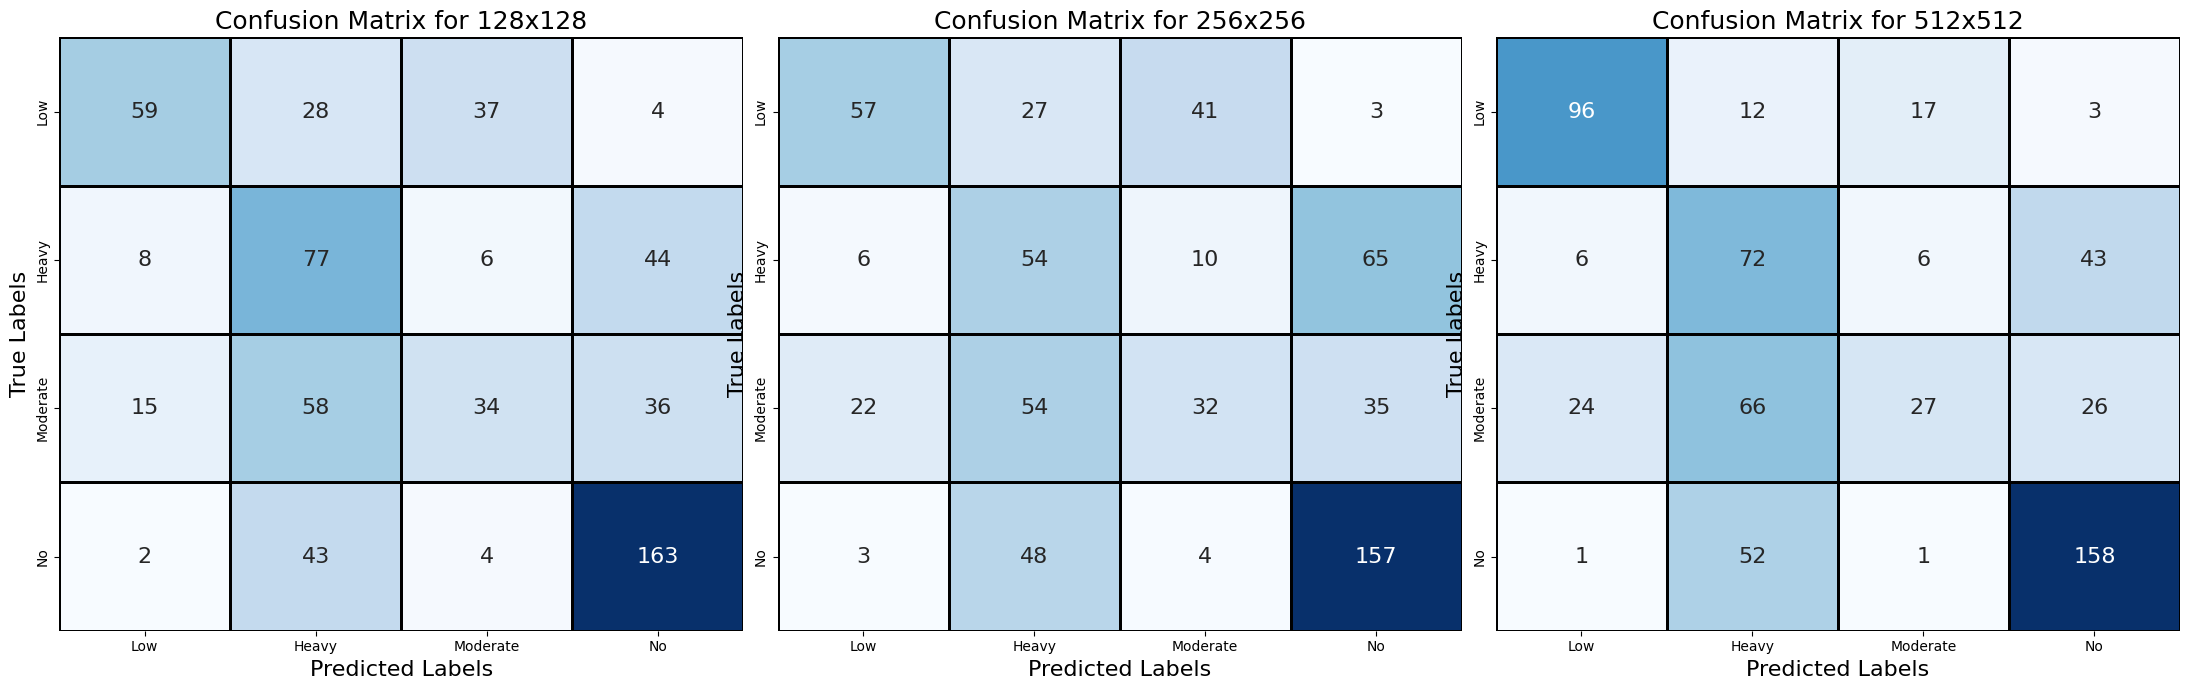

In [ ]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Specify paths to your three JSON files
json_file_128 = '/content/drive/MyDrive/model training(2)/json/metrics_size_128 (1).json'  # Update path
json_file_256 = '/content/drive/MyDrive/model training(2)/json/metrics_size_256.json'  # Update path
json_file_512 = '/content/drive/MyDrive/model training(2)/json/metrics_size_512 (1).json'  # Update path

# Create a figure with 3 subplots (one for each image size)
plt.figure(figsize=(22, 7))  # Increased figure size to fill the plot

# Paths and sizes
json_files = [json_file_128, json_file_256, json_file_512]
sizes = [128, 256, 512]
colors = ['blue', 'green', 'red']

# Define the class names
class_names = ['Low', 'Heavy', 'Moderate', 'No']

# Loop through the different image sizes and plot confusion matrix for each
for idx, (size, json_file, color) in enumerate(zip(sizes, json_files, colors)):
    try:
        # Load metrics from JSON
        with open(json_file, 'r') as f:
            metrics = json.load(f)

        # Extract confusion matrix
        conf_matrix = np.array(metrics['ensemble_metrics']['confusion_matrix'])

        # Plot confusion matrix
        plt.subplot(1, 3, idx + 1)  # Plot in the respective subplot
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    annot_kws={"size": 16},  # Increase annotation font size
                    xticklabels=class_names,
                    yticklabels=class_names,
                    linewidths=1, linecolor='black')  # Add lines between cells for clarity
        plt.title(f'Confusion Matrix for {size}x{size}', fontsize=18)  # Increase title font size
        plt.xlabel('Predicted Labels', fontsize=16)  # Increase x-label font size
        plt.ylabel('True Labels', fontsize=16)  # Increase y-label font size
        plt.tight_layout()

    except Exception as e:
        print(f"Error processing file for size {size}: {str(e)}")

# Adjust layout to fill space, making subplots fill the figure without gaps
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Remove gaps between subplots

# Save plot
save_path = '/content/drive/MyDrive/Confusion_Matrices_4_Types.png'  # Update path
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {save_path}")

# Display plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_best_epoch_accuracy_comparison(image_sizes, accuracies):
    """
    Plots a bar chart for the best epoch accuracy comparison across different image sizes.

    Args:
    image_sizes (list): List of image sizes (e.g., [128, 256, 512]).
    accuracies (list): Corresponding list of accuracies for each image size.
    """
    # Define bar colors for each image size
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue for 128, Orange for 256, Green for 512

    # Create bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(image_sizes, accuracies, color=colors, width=40)  # Adjusted width for better visibility

    # Add text labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom', fontsize=10)

    plt.xlabel('Image Size')
    plt.ylabel('Best Epochs Accuracy (%)')
    plt.title('Ensemble- Best Epochs Accuracy Comparison')
    plt.ylim(0, 1)  # Ensure y-axis starts at 0 and ends at 1
    plt.xticks(image_sizes, [f"{size}px" for size in image_sizes])  # Clearer label with pixel unit

    # Adding a custom legend
    plt.legend(bars, [f"{size}px" for size in image_sizes], title="Image Size")

    plt.show()

# Image sizes and their corresponding best accuracies
image_sizes = [128, 256, 512]
accuracies = [0.52427, 0.5242718458175659, 0.577049195766449]  # Accuracies for 128, 256 and 512 respectively

plot_best_epoch_accuracy_comparison(image_sizes, accuracies)

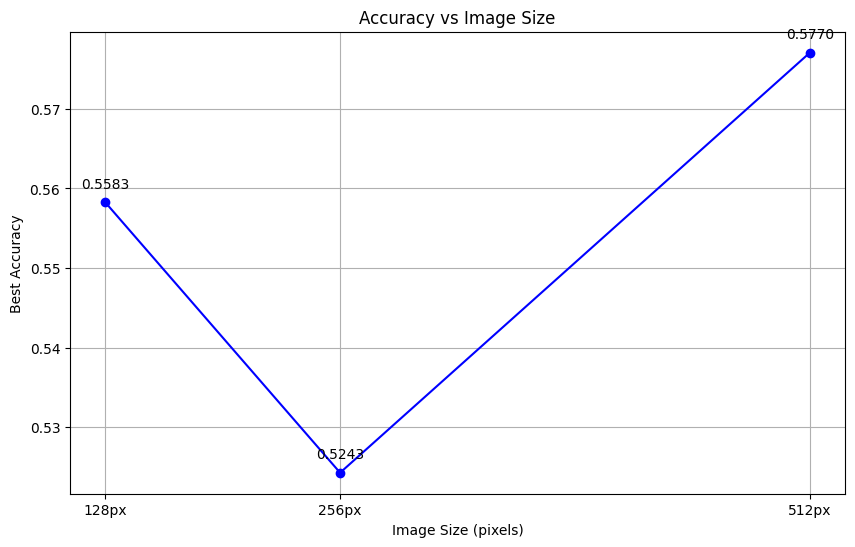

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_image_size(image_sizes, accuracies):
    """
    Plots a line graph for the accuracy comparison across different image sizes.

    Args:
    image_sizes (list): List of image sizes (e.g., [128, 256, 512]).
    accuracies (list): Corresponding list of best accuracies for each image size.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(image_sizes, accuracies, marker='o', linestyle='-', color='b')

    # Annotating each point with its value
    for i, txt in enumerate(accuracies):
        plt.annotate(f"{txt:.4f}", (image_sizes[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.xlabel('Image Size (pixels)')
    plt.ylabel('Best Accuracy')
    plt.title('Accuracy vs Image Size')
    plt.grid(True)
    plt.xticks(image_sizes, [f"{size}px" for size in image_sizes])  # Clearer label with pixel unit

    plt.show()

# Image sizes and their corresponding best accuracies
image_sizes = [128, 256, 512]
accuracies = [0.5582524538040161, 0.5242718458175659, 0.577049195766449]  # Best accuracies for each image size

plot_accuracy_vs_image_size(image_sizes, accuracies)

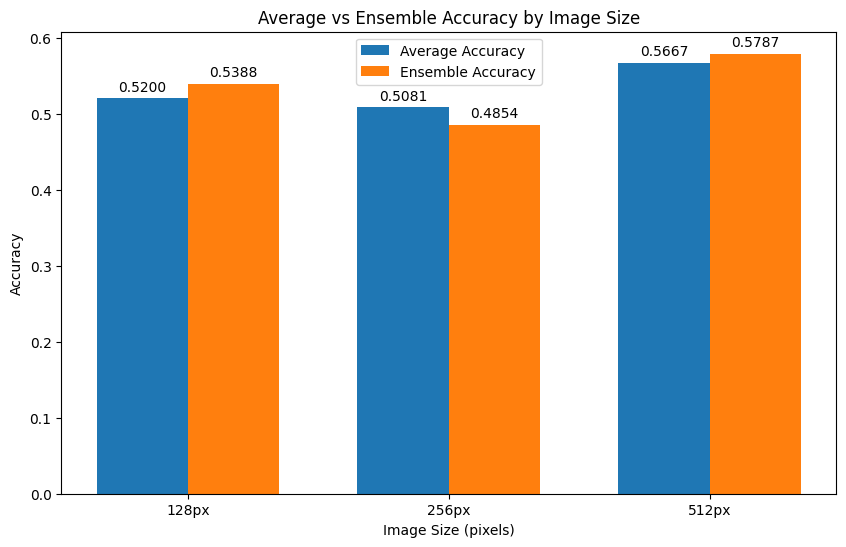

In [ ]:
import matplotlib.pyplot as plt

def plot_combined_accuracy_graph(image_sizes, average_accuracies, ensemble_accuracies):
    """
    Plots a combined bar chart for average and ensemble accuracies across different image sizes.

    Args:
    image_sizes (list): List of image sizes (e.g., [128, 256, 512]).
    average_accuracies (list): List of average accuracies for each image size.
    ensemble_accuracies (list): List of ensemble accuracies for each image size.
    """
    x = range(len(image_sizes))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar([i - width/2 for i in x], average_accuracies, width, label='Average Accuracy')
    rects2 = ax.bar([i + width/2 for i in x], ensemble_accuracies, width, label='Ensemble Accuracy')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Image Size (pixels)')
    ax.set_ylabel('Accuracy')
    ax.set_title('Average vs Ensemble Accuracy by Image Size')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{size}px" for size in image_sizes])
    ax.legend()

    # Annotate each bar within rects1 and rects2 for better clarity
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

# Image sizes and their corresponding accuracies
image_sizes = [128, 256, 512]
average_accuracies = [
    (0.5032362341880798 + 0.4983818829059601 + 0.5582524538040161) / 3,
    (0.49352750182151794 + 0.5242718458175659 + 0.5064724683761597) / 3,
    (0.577049195766449 + 0.5524590015411377 + 0.5704917907714844) / 3
]
ensemble_accuracies = [0.5388349514563107, 0.4854368932038835, 0.578688524590164]

plot_combined_accuracy_graph(image_sizes, average_accuracies, ensemble_accuracies)